#Load data

In [1]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the datset into a pandas dataframe
from joblib import load

df = load("/content/drive/My Drive/liveproject/mortgage_data_preprocessed.pkl.gz")

# Set up fairness metrics

In [4]:
# install AIF360
!pip install aif360
!pip install fairlearn

     |████████████████████████████████| 184kB 5.5MB/s 
     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=0a7eaf6f366f8418b5df389f65dc1653b9d19d0f8b73dadb6a2a6d2bdf85a4cf
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=75d4ea68ae7d9e1fcd26bcfe2dcde1e3e8b81ca6a4c397b3539ac44aac7baea3
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built shap memory-profiler
     |████████████████████████████████| 24.6MB 176kB/s 


In [5]:
# Set up the fairness metrics to be computed using AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
#from aif360.metrics import ClassificationMetric

privileged_group = [{'applicant_sex_name_Female': 0}] 
unprivileged_group = [{'applicant_sex_name_Female': 1}]

# Set up and fit reweighing

In [6]:
# Use the reweighing subjects technique

# Create a Binary Label Dataset from the training data

dataset = BinaryLabelDataset(df=df, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

# Use Reweighing to assign weights to each training data tuple

from aif360.algorithms.preprocessing import Reweighing

rw = Reweighing(unprivileged_group, privileged_group)

dataset_transformed = rw.fit_transform(dataset)

In [7]:
# View the resulting dataset with sample weights allocated
dataset_transformed

               instance weights  ... labels
                                 ...       
                                 ...       
instance names                   ...       
0                      0.938922  ...    0.0
1                      1.173511  ...    0.0
2                      1.173511  ...    0.0
3                      0.938922  ...    0.0
4                      0.938922  ...    0.0
...                         ...  ...    ...
165945                 0.834956  ...    1.0
165946                 1.095250  ...    1.0
165947                 1.095250  ...    1.0
165948                 1.095250  ...    1.0
165949                 1.095250  ...    1.0

[165950 rows x 37 columns]

In [8]:
# Convert the result to a more general format

df = dataset_transformed.convert_to_dataframe()[0]
instance_weights = dataset_transformed.instance_weights

# Compute and view fairness metrics

In [9]:
 # Create a BinaryLabelDatasetMetric

metric_transformed = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_group, privileged_group)

In [10]:
# Compute fairness metrics

import pandas as pd

fairness_df = pd.DataFrame(columns=["Metric", "Value", "Min", "Max"])
fairness_df.loc[0] = ['Disparate Impact'] + list((metric_transformed.disparate_impact(), 0.8, 1.2))
fairness_df.loc[1] = ['Statistical Parity Difference'] + list((metric_transformed.statistical_parity_difference(), -0.1, 0.1))

fairness_df

,Metric,Value,Min,Max
0,Disparate Impact,1.0,0.8,1.2
1,Statistical Parity Difference,0.0,-0.1,0.1


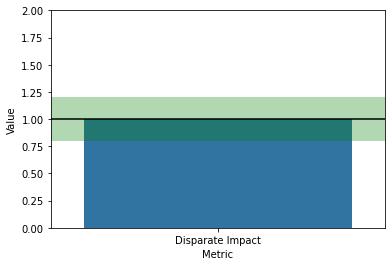

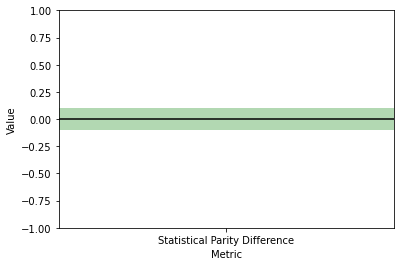

In [11]:
# Chart the metrics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

def plot_metrics(df_fair): 
  def plot_metric(metric, ylim):
    fig, ax = plt.subplots()
    ax = sns.barplot(data=metric, x="Metric", y="Value")
    plt.axhline(np.mean(metric[["Min", "Max"]].values), color='black')
    plt.ylim(*ylim)
    range_height = metric[["Max"]].values[0][0] - metric[["Min"]].values[0][0]
    ax.add_patch(patches.Rectangle((-1, metric[["Min"]].values[0][0]), 2 , range_height, facecolor="green", alpha=0.3))

  plot_metric(df_fair.iloc[[0]], (0, 2))
  plot_metric(df_fair.iloc[[1]], (-1, 1))

plot_metrics(fairness_df)